# Context Offloading와 Virtual File System을 활용한 LangGraph Agent 구축 튜토리얼

이 튜토리얼에서는 LangGraph 기반의 에이전트가 복잡한 작업을 수행할 때 발생하는 컨텍스트 윈도우의 급격한 증가를 효과적으로 관리하는 방법을 다룹니다. 특히, **context offloading** 기법을 활용하여 에이전트가 중간 결과나 중요한 정보를 파일 시스템에 저장하고 필요할 때마다 불러오는 전략을 소개합니다. 이를 위해 LangGraph의 상태(state)에 가상 파일 시스템을 구현하고, 파일을 읽고 쓰는 도구(tool)를 직접 만들어봅니다. 마지막으로, 실제 연구 에이전트 예제를 통해 이러한 도구들이 어떻게 활용되는지 실습합니다.

**🏆 주로 다루는 내용**
1. **Context Offloading 개념 및 필요성**  
   - 에이전트의 컨텍스트 윈도우가 커지는 문제와 이를 파일 시스템을 통해 효율적으로 관리하는 방법을 설명합니다.
2. **Virtual File System 설계 및 구현**  
   - LangGraph state 내에 dictionary 기반의 가상 파일 시스템을 설계하고, 파일 경로와 내용을 관리하는 구조를 소개합니다.
3. **File Tools (`ls`, `read_file`, `write_file`) 개발**  
   - 파일 목록 조회, 파일 읽기, 파일 쓰기 기능을 갖춘 도구를 직접 구현하고, 각 도구의 사용법과 프롬프트 설계 방법을 설명합니다.
4. **Agent State와 Reducer의 역할**  
   - 파일 시스템이 agent state에 어떻게 통합되는지, 그리고 reducer를 통해 파일 정보가 병합되는 원리를 다룹니다.
5. **연구 에이전트 예제 실습**  
   - 사용자의 요청을 파일로 저장하고, 저장된 파일을 읽어 답변하는 간단한 연구 에이전트를 구현하여 context offloading의 실제 활용 사례를 보여줍니다.

**✅ 주요 키워드**
- Context Offloading
- Virtual File System
- LangGraph
- Agent State
- Reducer
- Tool (`ls`, `read_file`, `write_file`)
- Command
- LangChain
- Agentic System

**⭐️ 사전 지식**
- Python 프로그래밍 기본 지식
- LangChain 및 LangGraph의 기본 구조와 개념
- 에이전트(Agent)와 툴(Tool) 기반 시스템의 동작 원리
- 상태(state) 관리 및 dictionary 자료구조 활용법

In [ ]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangChain-V1-Tutorial


## Context Offloading: Filesystem

복잡한 작업을 수행하는 과정에서 에이전트의 context window는 매우 빠르게 커질 수 있습니다. 실제로, 평균적으로 하나의 Manus 작업에서는 약 50회 이상의 tool 호출이 발생하며, 이로 인해 context가 급격히 누적됩니다. 이러한 문제를 효과적으로 해결하기 위한 강력한 방법이 바로 **context offloading**입니다. 이 기법은 파일 시스템을 활용하여, 모든 tool 호출 결과나 중간 산출물을 context window에 직접 저장하는 대신, 필요한 정보만 파일로 저장하고 필요할 때마다 불러오는 전략입니다. 자세한 내용은 [LangChain 블로그의 context engineering](https://blog.langchain.com/context-engineering-for-agents/)에서 확인할 수 있습니다.

이러한 방식은 실제 서비스 환경에서도 성공적으로 적용되고 있습니다. 예를 들어, [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)와 [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research)에서는 context offloading을 통해 에이전트의 메모리 관리를 최적화하고 있습니다. 또한, Anthropic의 [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Subagent%20output%20to%20a%20filesystem%20to%20minimize%20the%20%E2%80%98game%20of%20telephone.%E2%80%99)에서는 각 subagent가 작업 결과를 외부 파일 시스템에 저장하고, coordinator에게는 가벼운 참조 정보만 전달하는 구조를 사용합니다. 이를 통해 여러 에이전트를 거치면서 정보가 왜곡되는 'game of telephone' 현상을 방지하고, 새로운 subagent가 깨끗한 context로 시작하면서도 필요한 경우 저장된 연구 계획 등 중요한 정보를 다시 불러올 수 있습니다.

이처럼, 토큰이 많이 소모되는 context를 샌드박스 환경의 파일로 분리하여 저장하면, 에이전트는 메모리 사용을 효율적으로 관리하면서도 언제든 상세 정보를 다시 조회할 수 있습니다. 특히 코드, 보고서, 데이터 시각화 등 구조화된 결과물을 다룰 때, 또는 장기적인 연구 작업에서 중간 결과를 보존해야 할 때 매우 유용한 패턴입니다. 이러한 방식은 일반적인 coordinator를 통한 필터링보다 전문화된 프롬프트를 활용할 수 있어, 더 나은 결과를 얻을 수 있습니다.

### File Tools

LangGraph 에이전트의 컨텍스트를 효율적으로 관리하기 위해, 본 튜토리얼에서는 가상 파일 시스템(Virtual File System) 기반의 파일 도구를 직접 구현합니다. 이 방식은 실제 파일 시스템을 모방하여 LangGraph의 상태(state) 내에서 동작하며, 파일 경로를 key로, 파일 내용을 value로 저장하는 간단한 dictionary 구조를 사용합니다. 이러한 구조는 하나의 에이전트 대화(thread) 내에서 단기적으로 정보를 보존하는 데 적합하며, 여러 대화 스레드 간에 정보를 영구적으로 저장하는 용도에는 적합하지 않습니다.

파일 도구들은 LangGraph의 `Command` 타입을 활용하여 agent state를 업데이트하며, 이를 통해 가상 파일 시스템의 내용을 읽고 쓰는 작업이 가능합니다. 에이전트 실행 과정에서 파일 도구를 사용하면, 컨텍스트 내의 중요한 정보를 파일로 저장하거나 필요할 때 다시 불러올 수 있어, 메모리 관리와 정보 활용이 더욱 효율적으로 이루어집니다.

본 튜토리얼에서는 다음과 같은 세 가지 파일 도구를 구현합니다.

- `ls`: 현재 가상 파일 시스템에 저장된 파일 목록을 조회합니다.
- `read_file`: 지정한 파일의 내용을 읽어옵니다.
- `write_file`: 새로운 파일을 생성하거나 기존 파일에 정보를 저장합니다.

이러한 도구들은 LLM이 컨텍스트에 있는 정보를 파일로 저장하고, 이후 동일한 에이전트 또는 하위 에이전트가 해당 파일을 다시 읽어 활용할 수 있도록 설계되었습니다. 예를 들어, tool 호출 시 파일에 데이터를 저장하고, 반환 메시지에 파일명을 포함하여 LLM이 이후에 해당 파일을 읽거나 추가적인 처리를 할 수 있습니다.

파일 읽기 및 쓰기 도구는 줄바꿈 문자로 구분된 일반 텍스트를 처리하며, 내부적으로 `str.splitlines()`를 사용하여 데이터를 파싱합니다.

아래 프롬프트 예시에서는 각 도구의 동작 방식과 사용법을 상세히 설명합니다.

In [2]:
# 프롬프트 출력 함수 호출을 위한 유틸리티 함수 임포트
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

# 파일 목록 조회 도구 프롬프트 예시 출력, 도구 사용법 안내 목적
show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
# 파일 읽기 도구 프롬프트 예시 출력, 도구 사용법 안내 목적
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
# 파일 쓰기 도구 프롬프트 예시 출력, 도구 사용법 안내 목적
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

이제 실제로 파일 도구 함수를 구현해보겠습니다. 여기서 주목해야 할 두 가지 사항이 있습니다.

첫 번째는 `@tool(description=PROMPT)`의 활용입니다. `tool` 데코레이터에 `description="xyz"`가 포함되어 있으면, 해당 설명이 LLM에게 직접 전달되고 docstring은 무시됩니다. 따라서 도구의 동작 방식과 사용법을 충분히 설명하려면, 별도의 prompts 파일에 상세한 설명을 작성하는 것이 더 효율적입니다. 이렇게 하면 각 도구의 목적과 사용법을 명확하게 안내할 수 있습니다.

두 번째는 에러 메시지의 처리 방식입니다. 에이전트 시스템에서는 에러 메시지가 인간 사용자에게 전달되는 것이 아니라, LLM이 해당 정보를 바탕으로 작업을 재시도할 수 있도록 설계됩니다. 즉, 에러 메시지는 LLM이 상황을 인식하고 적절한 대응을 할 수 있도록 돕는 역할을 합니다.

이러한 구조를 통해, 각 도구의 설명과 에러 메시지가 LLM의 의사결정 과정에 직접적으로 반영되어, 보다 안정적이고 효율적인 에이전트 시스템을 구축할 수 있습니다.

In [5]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py
"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


# 가상 파일 시스템 내 파일 목록을 반환합니다.
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


# 파일을 읽어 반환합니다. 오프셋과 최대 라인 수를 지정할 수 있습니다.
@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    # 파일 시스템에서 파일을 조회합니다.
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    # 파일이 비어 있으면 안내 메시지를 반환합니다.
    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    # 파일 내용을 줄 단위로 분할하고 오프셋 및 제한을 적용합니다.
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    # 오프셋이 파일 길이를 초과하면 에러 메시지를 반환합니다.
    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    # 각 줄에 번호를 붙이고 2000자까지 잘라서 결과를 만듭니다.
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    # 결과를 문자열로 합쳐 반환합니다.
    return "\n".join(result_lines)


# 파일에 내용을 기록하고 상태를 갱신하는 커맨드를 반환합니다.
@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    # 파일 시스템에 파일을 저장합니다.
    files = state.get("files", {})
    files[file_path] = content
    # 파일 업데이트 메시지와 함께 커맨드를 반환합니다.
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )


Overwriting ../src/deep_agents_from_scratch/file_tools.py


## State와 Reducer 다시 살펴보기

앞서 파일 상태와 reducer에 대해 정의하였으나, 구체적인 설명은 다루지 않았습니다. 이번에는 이 부분을 자세히 설명합니다.

`DeepAgentState`에서는 `files`가 파일 이름을 key로, 파일 내용을 value로 갖는 dictionary 형태로 정의되어 있습니다. 즉, 각 파일의 이름과 그에 해당하는 내용이 쌍으로 저장됩니다. 파일 시스템에 새로운 파일을 추가하거나 기존 파일을 수정할 때는, `write_file` 도구에서 반환하는 `Command`가 실행되면서 `file_reducer`가 동작합니다.

`file_reducer` 함수는 기존 상태에 저장된 파일 정보(`left`)와 새롭게 추가되거나 수정된 파일 정보(`right`)를 병합하는 역할을 합니다. 이때 Python의 `{**left, **right}` 문법을 사용하여, 동일한 파일명이 있을 경우 새 값(`right`)이 기존 값(`left`)을 덮어쓰게 됩니다. 즉, 항상 최신 파일 정보가 반영되도록 설계되어 있습니다.

아래는 실제로 사용되는 `file_reducer` 함수와 `DeepAgentState` 클래스의 예시입니다.

```python
def file_reducer(left, right):
    """두 개의 파일 dictionary를 병합하며, 오른쪽 값이 우선 적용됩니다.

    agent state의 files 필드에 대한 reducer 함수로 사용되며,
    가상 파일 시스템의 점진적 업데이트를 지원합니다.

    Args:
        left: 기존 파일 정보(dictionary)
        right: 새로 추가/수정된 파일 정보(dictionary)

    Returns:
        병합된 dictionary (동일한 key는 right 값으로 덮어쓰기)
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """작업 추적 및 가상 파일 시스템을 포함하는 확장 agent state.

    LangGraph의 AgentState를 상속하며,
    - todos: 작업 계획 및 진행 상황 추적용 Todo 리스트
    - files: 파일명과 내용을 매핑하는 가상 파일 시스템(dictionary)
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]
```

이 구조를 통해 LangGraph 기반 에이전트는 파일 시스템의 상태를 효율적으로 관리할 수 있으며, 여러 번의 파일 쓰기 작업이 발생해도 항상 최신 정보가 유지됩니다. 또한, reducer를 활용함으로써 각 도구의 실행 결과가 agent state에 자연스럽게 반영되어, 복잡한 작업 흐름에서도 일관된 파일 관리가 가능합니다.

이제 앞서 구현한 가상 파일 시스템과 파일 도구를 실제로 활용해보겠습니다. 간단한 연구 에이전트 예제를 통해, 사용자의 요청을 파일로 저장한 뒤, 해당 파일을 다시 읽어 답변하는 과정을 실습합니다.

이러한 방식은 특히 **장기적인 에이전트 작업(long-running agent trajectories)** 에서 매우 유용하게 활용됩니다. 본 예제에서는 모든 정보가 context에 쉽게 유지되지만, 실제 서비스 환경이나 복잡한 에이전트 시스템에서는 context의 크기가 빠르게 증가하거나 일부 정보가 압축 또는 삭제될 수 있습니다. 이때, 중요한 정보를 압축 전에 파일로 저장하고, 필요할 때 다시 불러오는 전략은 **스마트한 context 관리(context engineering)** 방법으로 평가받고 있습니다.

실제로, Anthropic의 [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)에서도 이러한 파일 기반 정보 저장 및 복원이 장기 대화나 복잡한 작업 흐름에서 효과적으로 활용되고 있습니다.

이제, 가상 파일 시스템을 활용한 연구 에이전트 예제를 통해 context offloading의 실제 적용 방법을 살펴보겠습니다.

In [6]:
# 가상 파일 시스템 활용 방법 안내 문자열, 에이전트의 컨텍스트 저장 및 복원 절차 설명
FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.

## Workflow Process
1. **Orient**: Use ls() to see existing files before starting work
2. **Save**: Use write_file() to store the user's request so that we can keep it for later
3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that you directly answer the user's question."""

# 모의 연구 에이전트 지침 문자열, 웹 검색 도구 단일 호출 및 결과 활용 안내
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# 전체 프롬프트 구성, 파일 시스템 사용법과 연구 지침을 결합하여 에이전트에게 전달
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
# 프롬프트 출력 함수 호출, 에이전트에게 작업 흐름 및 도구 사용법 안내 목적
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that  │
│  you directly answer the user's question.                                                                       │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer    │
│  the user's question.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

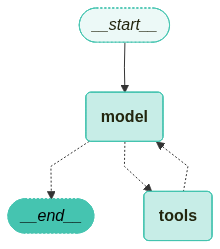

In [8]:
# 이미지 출력 및 에이전트 그래프 시각화 목적
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

# from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

from langchain_teddynote.graphs import visualize_graph

# 웹 검색 결과 모의 데이터, MCP 프로토콜 설명 포함
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed
by Anthropic to enable seamless integration between AI models and external systems like
tools, databases, and other services. It acts as a standardized communication layer,
allowing AI models to access and utilize data from various sources in a consistent and
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants
to external services by providing a unified language for data exchange. """


# 웹 검색 도구 정의, 실제 검색 대신 모의 결과 반환
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Anthropic Claude Sonnet 모델 초기화, 온도 0.0으로 설정
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
# 파일 도구 및 웹 검색 도구 리스트 생성, 에이전트에 전달
tools = [ls, read_file, write_file, web_search]

# 시스템 프롬프트와 상태 스키마 지정, 에이전트 생성
agent = create_agent(
    model, tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 에이전트의 내부 그래프 구조 시각화, Mermaid PNG로 출력
visualize_graph(agent)

그래프의 시작 상태에서는 `state` 내에 `files`가 없는 상태에서 사용자의 연구 요청이 입력됩니다.

즉, 에이전트는 초기에는 어떠한 파일도 보유하지 않은 상태로 작업을 시작하며, 사용자의 요청을 받아 필요한 정보를 가상 파일 시스템에 저장하고 관리하는 과정을 거치게 됩니다. 이러한 초기 상태 설정은 실제 서비스 환경에서 에이전트가 새로운 대화나 작업을 시작할 때의 전형적인 흐름을 반영합니다.

이처럼 파일 시스템이 비어 있는 상태에서 출발하여 사용자의 요청을 받아 점진적으로 파일을 생성하고 활용하는 방식은 **context offloading** 전략의 핵심적인 패턴입니다.

In [ ]:
# 에이전트에게 사용자 메시지와 빈 파일 시스템을 입력으로 전달하여 실행 결과 반환
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
# 에이전트 실행 결과의 메시지 리스트를 포맷팅하여 출력
format_messages(result["messages"])

가상 파일 시스템에 파일이 정상적으로 저장된 것을 확인할 수 있습니다.  
이렇게 저장된 파일은 이후 에이전트가 필요할 때 언제든지 `read_file` 도구를 통해 내용을 조회하거나, 추가적인 정보를 기록하는 데 활용할 수 있습니다.  
이러한 파일 기반의 컨텍스트 관리 방식은 복잡한 작업 흐름에서도 중요한 정보를 안정적으로 보존하고, 에이전트의 메모리 사용을 효율적으로 최적화하는 데 큰 도움이 됩니다.

In [ ]:
# 에이전트 실행 결과에서 가상 파일 시스템의 현재 상태(파일 목록 및 내용) 조회
result["files"]

**실행 트레이스 확인**

에이전트의 실행 과정이나 동작 흐름을 명확하게 파악하고자 할 때, LangChain Smith 플랫폼에서 제공하는 트레이스 기능을 활용할 수 있습니다. 아래 링크를 통해 실제 에이전트 실행의 상세 로그와 각 단계별 상태 변화를 시각적으로 확인할 수 있습니다.

- [실행 트레이스 바로가기](https://smith.langchain.com/public/b03e20b4-e908-488d-84a9-8f891d17addd/r)

이러한 트레이스는 에이전트가 파일 시스템을 어떻게 활용하는지, 각 도구(tool)가 어떤 순서로 호출되는지, 그리고 상태(state)가 어떻게 변화하는지 한눈에 파악할 수 있도록 도와줍니다. 실습 과정에서 예상과 다른 결과가 발생하거나, 에이전트의 동작 원리를 더 깊이 이해하고자 할 때 매우 유용하게 활용할 수 있습니다.

실제 서비스 환경이나 복잡한 에이전트 시스템을 개발할 때도, 트레이스 기능을 적극적으로 활용하면 디버깅(debugging)과 최적화(optimization)에 큰 도움이 됩니다.

In [ ]:
# 가상 파일 시스템 내 파일 목록 반환 함수 정의, 파일명 리스트 형태로 반환
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    # 가상 파일 시스템에서 파일 목록 추출, files 키가 없으면 빈 딕셔너리 사용
    return list(state.get("files", {}).keys())


# 파일 내용 읽기 함수 정의, 오프셋 및 최대 라인 수 지정 가능
@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    # 가상 파일 시스템에서 파일 딕셔너리 조회, files 키가 없으면 빈 딕셔너리 사용
    files = state.get("files", {})
    # 파일 존재 여부 확인, 없으면 에러 메시지 반환
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    # 파일 내용이 비어 있는 경우 안내 메시지 반환
    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    # 파일 내용을 줄 단위로 분할, 오프셋 및 최대 라인 수 적용
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    # 오프셋이 파일 길이 초과 시 에러 메시지 반환
    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    # 각 줄에 번호 부여, 최대 2000자까지 잘라서 결과 리스트 생성
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    # 결과 리스트를 문자열로 합쳐서 반환
    return "\n".join(result_lines)


# 파일에 내용 기록 및 상태 갱신 커맨드 반환 함수 정의
@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    # 가상 파일 시스템에서 파일 딕셔너리 조회, files 키가 없으면 빈 딕셔너리 사용
    files = state.get("files", {})
    # 파일 시스템에 파일명과 내용 저장, 기존 파일이면 덮어쓰기
    files[file_path] = content
    # 파일 업데이트 메시지 포함 커맨드 객체 반환, 상태 업데이트 및 메시지 전달 목적
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )